<h1><center> Group Assignment: Bird Classifier  </center></h1>

In [1]:
# Import PyTorch and supporting libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torch.utils.data.sampler import WeightedRandomSampler

from PIL import Image

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Use GPU if available, else fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
# Step 1: Load in data sets and set variables

# Load the CSV file
# train data
train_csv_path = "C:/Users/Gebruiker/Documents/UVA/Vakken met code/AML/AML2024-Feather-in-Focus/data/train_images.csv"
train_label_df = pd.read_csv(train_csv_path)

# test data
test_csv_path = "C:/Users/Gebruiker/Documents/UVA/Vakken met code/AML/AML2024-Feather-in-Focus/data/test_images_path.csv"  # Update this path
test_label_df = pd.read_csv(test_csv_path)



batch_size = 32
learning_rate = 0.001
num_epochs = 16

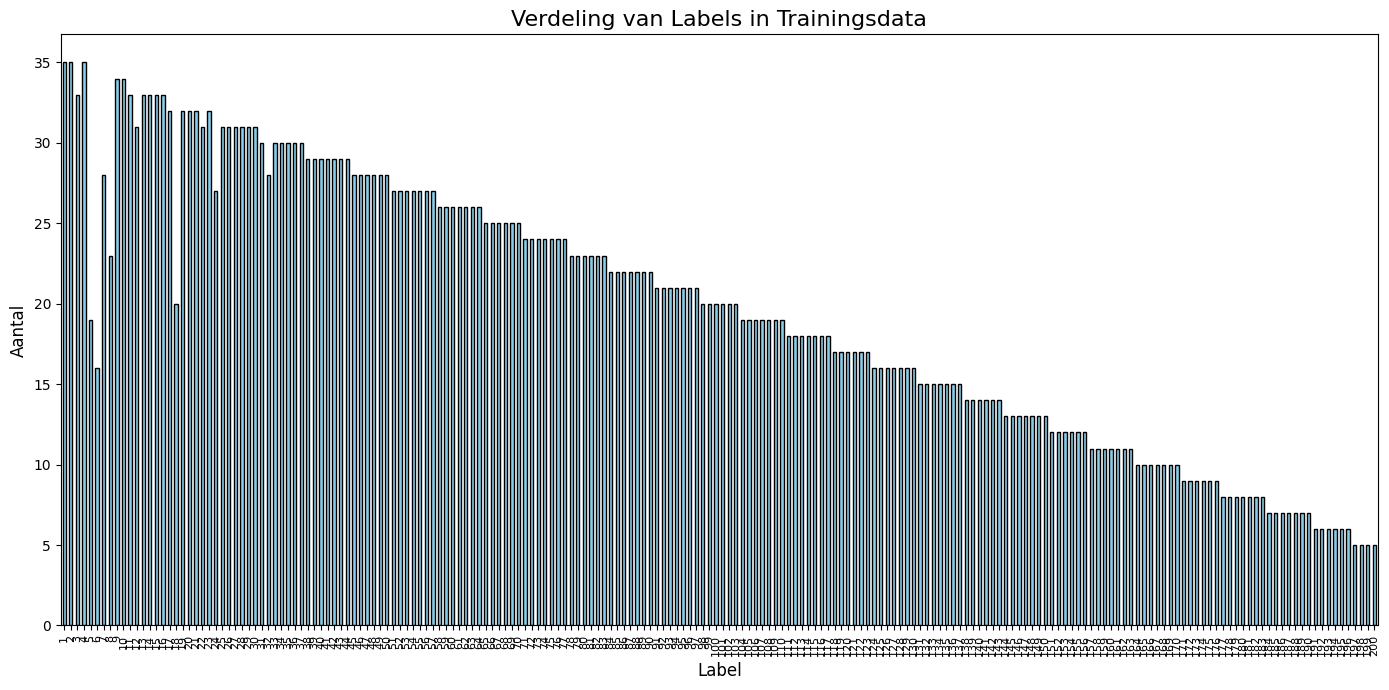

In [4]:
# Groepeer op label en tel het aantal voorkomen
label_counts = train_label_df['label'].value_counts()

# Plot de verdeling
plt.figure(figsize=(14, 7))
label_counts.sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Verdeling van Labels in Trainingsdata', fontsize=16)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Aantal', fontsize=12)
plt.xticks(rotation=90, fontsize=8)  # Labels draaien voor betere leesbaarheid
plt.tight_layout()  # Zorg dat alles past
plt.show()

In [5]:
# Step 2: Create a Custom Dataset

class ImageLabelDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (str): Path to the CSV file containing image paths and labels.
            transform (callable, optional): Transformations to apply to the images.
        """
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        # Return the total number of samples
        return len(self.data)

    def __getitem__(self, idx):
        # Get the image path and label for the given index
        img_path = "./images/"+ self.data.iloc[idx, 0]  # Image file path
        label = self.data.iloc[idx, 1] if self.data.shape[1] > 1 else 0   # Corresponding label

        # Load the image
        image = Image.open(img_path).convert("RGB")  # Ensure 3 channels (RGB)

        # Apply transformations (if any)
        if self.transform:
            image = self.transform(image)

        # Convert label to tensor
        label = torch.tensor(label, dtype=torch.long)

        return image, label


In [6]:
# Define transformations with data augmentation
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),                # Resize images to 128x128
    transforms.RandomHorizontalFlip(p=0.5),      # Randomly flip images horizontally with a 50% probability
    transforms.RandomRotation(degrees=15),       # Randomly rotate images within 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly adjust brightness, contrast, saturation, and hue
    transforms.ToTensor(),                       # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize values
])

# Test set transformations (no augmentation, just resizing and normalization)
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),               # Resize images to 128x128
    transforms.ToTensor(),                       # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize values
])


In [7]:
# # Step 3: Define Transformations

# # Define transformations (resize, convert to tensor, normalize)
# transform = transforms.Compose([
#     transforms.Resize( (128, 128)),  # Resize to 128x128
#     transforms.ToTensor(),          # Convert to tensor
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize values
# ])

In [9]:
# Bereken het aantal voorbeelden per klasse
class_counts = train_label_df['label'].value_counts()

# Gewicht toewijzen: minder voorbeelden -> hoger gewicht
class_weights = 1.0 / class_counts
sample_weights = train_label_df['label'].map(class_weights).values

# WeightedRandomSampler gebruiken
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Instantiate de datasets
train_dataset = ImageLabelDataset(csv_file=train_csv_path, transform=train_transform)
test_dataset = ImageLabelDataset(csv_file=test_csv_path, transform=test_transform)

# Maak een DataLoader voor batchverwerking met sampler
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Testdataset blijft hetzelfde


In [ ]:
# # Step 4: Instantiate the Dataset and DataLoader

# # Instantiate the dataset
# train_dataset = ImageLabelDataset(csv_file=train_csv_path, transform=transform)
# test_dataset = ImageLabelDataset(csv_file=test_csv_path, transform=transform)

# # Create a DataLoader for batch processing
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False) # set batch size to 1 so that we check all 4000 images

Run the below code to see the difference if you.

In [ ]:
#print(f"train dataset size: {len(train_dataset)}, train data size after data loader:  {len(ttrain_dataloader)}")
#print(f"test dataset size: {len(test_dataset)}, test data size after data loader:  {len(test_dataloader)}") 

In [10]:
print("Current working directory:", os.getcwd())
# Change the working directory to the folder containing the files
os.chdir("C:/Users/Gebruiker/Documents/UVA/Vakken met code/AML/AML2024-Feather-in-Focus/data")
print("Current working directory:", os.getcwd())

Current working directory: c:\Users\Gebruiker\Documents\UVA\Vakken met code\AML\AML2024-Feather-in-Focus
Current working directory: C:\Users\Gebruiker\Documents\UVA\Vakken met code\AML\AML2024-Feather-in-Focus\data


In [11]:
# Step 5: Verify the Dataset

# Iterate through the train DataLoader
for images, labels in train_dataloader:
    print(f"Batch of images: {images.shape}")  # Should be (batch_size, channels, height, width)
    print(f"Batch of labels: {labels}")       # Should match the batch_size
    break

# Iterate through the test DataLoader
for images, labels in test_dataloader:
    print(f"\nBatch of images: {images.shape}")  # Should be (batch_size, channels, height, width)
    print(f"Batch of labels: {labels}")       # Should match the batch_size
    break

Batch of images: torch.Size([32, 3, 128, 128])
Batch of labels: tensor([108, 137,  50,  44,  27,  55, 191,  23,  91,  30, 175, 103,  36,  84,
         35, 109, 175,  97, 183,  54,  77, 167, 157, 146, 101, 199, 151, 162,
         16,  30,  47, 167])

Batch of images: torch.Size([1, 3, 128, 128])
Batch of labels: tensor([1])


In [12]:
# Step 6: Create CNN model

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Define layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)  # Input channels: 3, Output channels: 16
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1) # Input: 16, Output: 32
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)                  # Downsample by 2x
        self.fc1 = nn.Linear(32 * 32 * 32, 128)                              # Fully connected layer
        self.fc2 = nn.Linear(128, 200)                                     # Output layer (200 classes)
    
    def forward(self, x):
        
        #print(f"Input shape: {x.shape}")  # Debugging input shape
        x = self.pool(torch.relu(self.conv1(x)))  # Conv1 -> ReLU -> MaxPool
        #print(f"After Conv1: {x.shape}")
        x = self.pool(torch.relu(self.conv2(x)))  # Conv2 -> ReLU -> MaxPool
        #print(f"After Conv2: {x.shape}")
        x = x.view(x.size(0), -1)                # Flatten for fully connected layers
        #print(f"After Flatten: {x.shape}")
        x = torch.relu(self.fc1(x))              # FC1 -> ReLU
        #print(f"After Fully Connected: {x.shape}")
        x = self.fc2(x) # FC2 (logits output)

        return x

# Instantiate the model and move it to the appropriate device
model = CNN().to(device)

In [13]:
# Step 7: Set loss and optimiser function

# Loss function: CrossEntropyLoss (good for classification tasks)
criterion = nn.CrossEntropyLoss()

# Optimizer: Adam optimizer with a learning rate
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Step 8: Training loop

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    for images, labels in train_dataloader:
        # Move data to device
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels - 1) # to combat the out of bounds issue I set labels - 1 

        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss for display
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_dataloader):.4f}")


Epoch [1/16], Loss: 5.2580
Epoch [2/16], Loss: 5.0549
Epoch [3/16], Loss: 4.8364
Epoch [4/16], Loss: 4.6224
Epoch [5/16], Loss: 4.3458
Epoch [6/16], Loss: 4.1562


In [ ]:
#Step 9: Evaluation loop

model.eval()  # Set model to evaluation mode
predictions = []  # To store predictions
count = 0 # this keeps track of which image we are currently predicting for

with torch.no_grad():  # No need to compute gradients during evaluation
    for images, labels in test_dataloader: 
        
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        predicted += 1 # to counteract the out of bounds issue, we need to do y+1

        # get the current images' image path
        image_path = test_label_df["image_path"][count]

        # Extract the file name without the extension
        image_name = os.path.splitext(os.path.basename(image_path))[0]
        
        # Store the image path and prediction
        predictions.append((image_name, predicted.item()))
        count += 1

# Save predictions to Excel
df = pd.DataFrame(predictions, columns=['id', 'label'])
df.to_csv("predictions.csv", index=False)


Below is a parameter log with their kaggle results.

The format will always be training batch size, learing rate and number of epochs, optimiser :-
1. batch size = 32, learning rate = 0.001, number of epochs = 15, optimizer = ADAM, Kaggle score = 0.00525
2. batch size = 32, learning rate = 0.01, number of epochs = 15, optimizer = ADAM, Kaggle score = 0.00500
3. batch size = 32, learning rate = 0.01, number of epochs = 10, optimizer = ADAM, Kaggle score = 0.00600
4. batch size = 32, learning rate = 0.01, number of epochs = 8, optimizer = ADAM, Kaggle score = 0.00525
5. batch size = 4, learning rate = 0.01, number of epochs = 10, optimizer = SDG, Kaggle score = 